This notebook tests all the visulizations for the MTA turnstile data

# Setup

In [1]:
# imports a library 'pandas', names it as 'pd'
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns


# enables inline plots, without it plots don't show up in the notebook
%matplotlib inline

/anaconda/envs/py35/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
print("Pandas version:",pd.__version__)
print("Numpy version:",np.__version__)

Pandas version: 0.20.2
Numpy version: 1.12.1


In [3]:
# various options in pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 25)
pd.options.display.float_format = '{:,.2f}'.format
#pd.set_option('display.precision',3)

# import data

In [4]:
df = pd.DataFrame.from_csv('clean_data.csv', parse_dates=['parsed_datetime','parsed_date']) 

/anaconda/envs/py35/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2802: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
/anaconda/envs/py35/lib/python3.5/site-packages/numpy/lib/arraysetops.py:395: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10269875 entries, 0 to 10269874
Data columns (total 18 columns):
control_area         object
unit                 object
scp                  object
station              object
linename             object
division             object
date                 object
time                 object
desc                 object
cum_entries          int64
cum_exits            int64
parsed_datetime      datetime64[ns]
shift_cum_entries    float64
shift_cum_exits      float64
shift_datetime       object
entries              float64
exits                float64
parsed_date          datetime64[ns]
dtypes: datetime64[ns](2), float64(4), int64(2), object(10)
memory usage: 1.5+ GB


In [6]:
df.head()

,control_area,unit,scp,station,linename,division,date,time,desc,cum_entries,cum_exits,parsed_datetime,shift_cum_entries,shift_cum_exits,shift_datetime,entries,exits,parsed_date
0,A002,R051,02-00-00,59 ST,NQR456,BMT,06/18/2016,00:00:00,REGULAR,5704958,1934814,2016-06-18 00:00:00,nan,nan,NaN,nan,nan,2016-06-18
1,A002,R051,02-00-00,59 ST,NQR456,BMT,06/18/2016,04:00:00,REGULAR,5704958,1934829,2016-06-18 04:00:00,"5,704,958.00","1,934,814.00",2016-06-18 00:00:00,0.00,15.00,2016-06-18
2,A002,R051,02-00-00,59 ST,NQR456,BMT,06/18/2016,08:00:00,REGULAR,5704958,1934886,2016-06-18 08:00:00,"5,704,958.00","1,934,829.00",2016-06-18 04:00:00,0.00,57.00,2016-06-18
3,A002,R051,02-00-00,59 ST,NQR456,BMT,06/18/2016,12:00:00,REGULAR,5704958,1934993,2016-06-18 12:00:00,"5,704,958.00","1,934,886.00",2016-06-18 08:00:00,0.00,107.00,2016-06-18
4,A002,R051,02-00-00,59 ST,NQR456,BMT,06/18/2016,16:00:00,REGULAR,5704958,1935069,2016-06-18 16:00:00,"5,704,958.00","1,934,993.00",2016-06-18 12:00:00,0.00,76.00,2016-06-18


In [7]:
df.parsed_datetime.describe()

count                10269875
unique                 608678
top       2017-06-21 08:00:00
freq                     2420
first     2016-06-18 00:00:00
last      2017-06-23 23:59:58
Name: parsed_datetime, dtype: object

In [8]:
df['day_of_week'] = df.parsed_date.apply(lambda x: x.isoweekday())

# Plots

In [89]:
# create dataset with entries+exits, entries, exits
station = df.groupby(['station','date'])['entries','exits'].sum().groupby(['station']).mean()\
.rename(columns={'entries': 'daily_entries', 'exits': 'daily_exits'})

In [90]:
station['daily_ridership'] = (station.daily_entries + station.daily_exits)/2
station['exits_rank'] = station.daily_exits.rank(ascending = False)
station['ridership_rank'] = station.daily_ridership.rank(ascending = False)
station = station[(station.ridership_rank <=20) | (station.exits_rank <=20)].sort_values(['ridership_rank','exits_rank'])

In [229]:
station_list = station.index.tolist()
day_dict = {1: 'Mon', 2: "Tue", 3:'Wed', 4:'Thu', 5:'Fri',6:'Sat', 7:'Sun'}


In [244]:
# define brunch time as from 8AM - noon
brunch = df[(df.time <= '12:00:00') & (df.time > '08:00:00')].groupby(['station','date','day_of_week']).exits.sum()\
.groupby(['station','day_of_week']).mean().reset_index().rename(columns={'exits': 'average_brunch_exits'})

bruch = brunch[brunch.station.isin(station_list)]
brunch = brunch.replace({'day_of_week': day_dict})

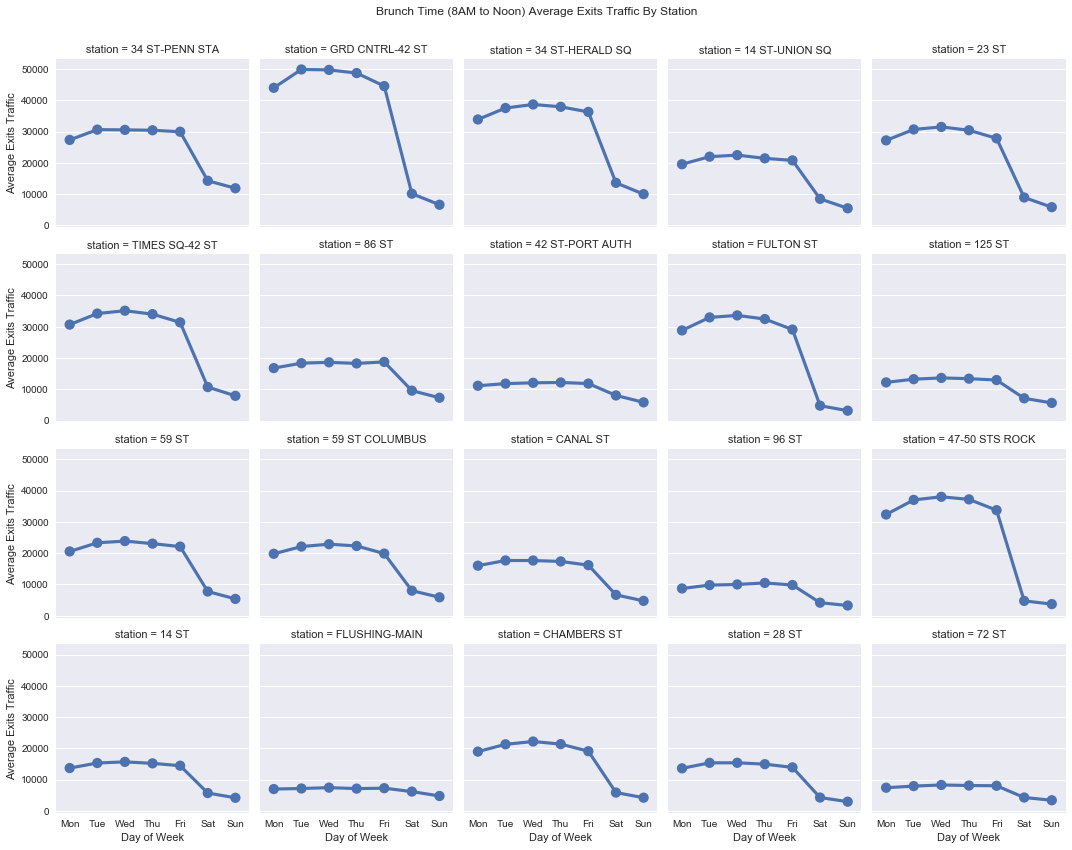

In [249]:
g = sns.FacetGrid(data = brunch, col='station',col_order =station.index, sharey= True, sharex=True, col_wrap = 5)
g.map(sns.pointplot, 'day_of_week','average_brunch_exits', \
      order = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
g.set_xlabels('Day of Week')
g.set_ylabels('Average Exits Traffic')

plt.subplots_adjust(top=0.92)
g.fig.suptitle('Brunch Time (8AM to Noon) Average Exits Traffic By Station')

g.savefig('Brunch_Exits.png')



In [246]:
# define dinner time as from 4pm to 8pm 

dinner = df[(df.time <= '20:00:00') & (df.time > '16:00:00')].groupby(['station','date','day_of_week']).exits.sum()\
.groupby(['station','day_of_week']).mean().reset_index().rename(columns={'exits': 'average_brunch_exits'})

dinner = dinner[dinner.station.isin(station_list)]

dinner = dinner.replace({'day_of_week': day_dict})

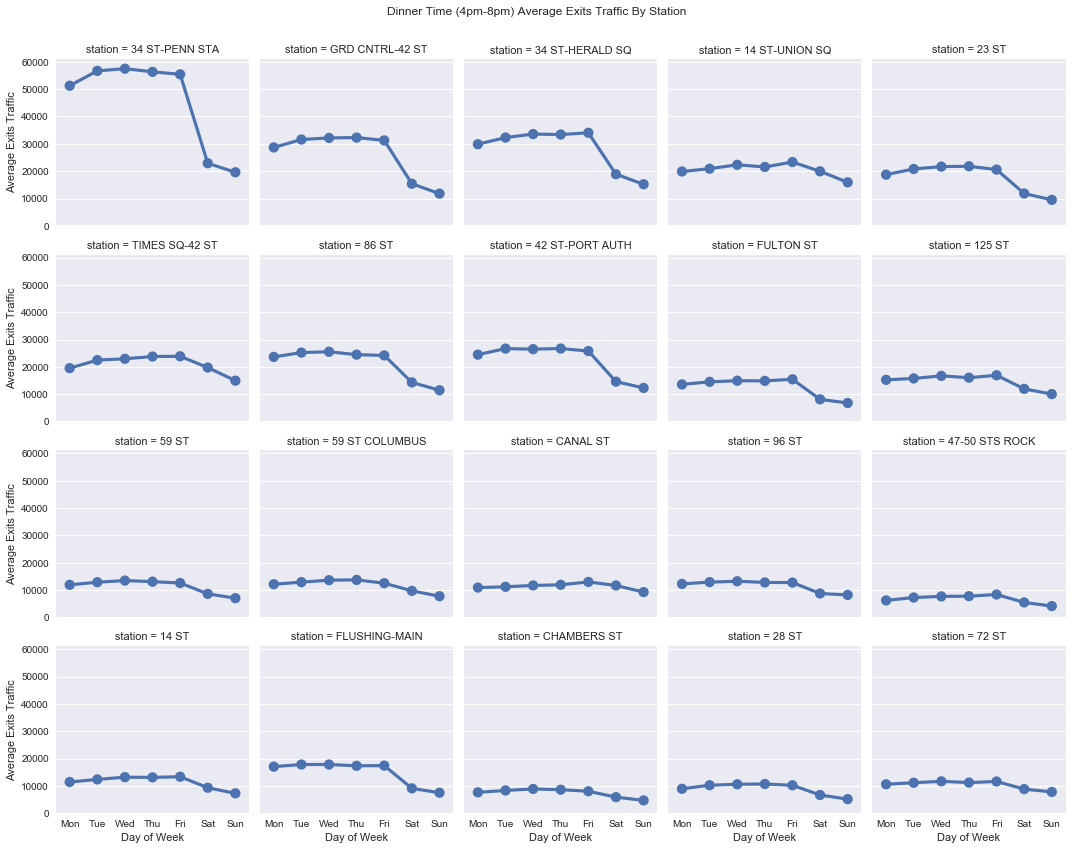

In [250]:
gd = sns.FacetGrid(data = dinner, col='station',col_order =station.index, sharey= True, sharex=True, col_wrap = 5)
gd.map(sns.pointplot, 'day_of_week','average_brunch_exits', \
      order = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
gd.set_xlabels('Day of Week')
gd.set_ylabels('Average Exits Traffic')

plt.subplots_adjust(top=0.92)
gd.fig.suptitle('Dinner Time (4pm-8pm) Average Exits Traffic By Station')

gd.savefig('Dinner_Exits.png')

